In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:,1].values.tolist()
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [3]:
# 중복된 피처명 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [6]:
# 중복된 피처명을 새로운 이름으로 변경
def get_new_feature_name_df(feature_name_df):
    feature_dup_df = pd.DataFrame(feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt']) #cumcount : 몇 번째 중복
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                               if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

new_feature_name_df = get_new_feature_name_df(feature_name_df)
new_feature_name_df.head()

,column_index,column_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [7]:
# 중복 피처명 재확인
new_feature_dup_df = new_feature_name_df.groupby('column_name').count()
print(new_feature_dup_df[new_feature_dup_df['column_index']>1].count())

column_index    0
dup_cnt         0
dtype: int64


In [9]:
# 리스트 객체로 다시 변환
feature_name = new_feature_name_df.iloc[:,1].values.tolist()

In [12]:
# 데이터셋 가져오기
x_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
x_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)

y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])

print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [13]:
y_train.value_counts()

action
6         1407
5         1374
4         1286
1         1226
2         1073
3          986
dtype: int64

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 기본 하이퍼 파라미터로 예측
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('{0:4f}'.format(accuracy))

0.862572


In [22]:
# GridSearchCV 최적 파라미터로 예측
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [6,8,10,12,16,20,24], 'min_samples_split' : [16, 24]}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)
print('최고 평균 정확도 수치 : {0:4f}'.format(grid_cv.best_score_))
print('최적 하이퍼 파라미터 :', grid_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
최고 평균 정확도 수치 : 0.854879
최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [23]:
# 예측 성능 변화 확인
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]

,param_max_depth,param_min_samples_split,mean_test_score
0,6,16,0.847662
1,6,24,0.846575
2,8,16,0.854879
3,8,24,0.851342
4,10,16,0.852705
5,10,24,0.854064
6,12,16,0.845768
7,12,24,0.846175
8,16,16,0.847127
9,16,24,0.849439


In [26]:
# 테스트 데이터 셋으로 변화 측정
max_depths = [6,8,10,12,16,20,24]
min_samples_split = [16, 24]
for depth in max_depths:
    for min_sample in min_samples_split:
        dt_clf = DecisionTreeClassifier(max_depth = depth, min_samples_split = min_sample)
        dt_clf.fit(x_train, y_train)
        pred = dt_clf.predict(x_test)
        accuracy = accuracy_score(y_test, pred)
        print('max_depth = {0} min_samples_split = {1} 정확도 : {2:4f}'.format(depth, min_sample, accuracy))

max_depth = 6 min_samples_split = 16 정확도 : 0.856125
max_depth = 6 min_samples_split = 24 정확도 : 0.854768
max_depth = 8 min_samples_split = 16 정확도 : 0.872073
max_depth = 8 min_samples_split = 24 정확도 : 0.869698
max_depth = 10 min_samples_split = 16 정확도 : 0.865965
max_depth = 10 min_samples_split = 24 정확도 : 0.865965
max_depth = 12 min_samples_split = 16 정확도 : 0.857822
max_depth = 12 min_samples_split = 24 정확도 : 0.861215
max_depth = 16 min_samples_split = 16 정확도 : 0.861893
max_depth = 16 min_samples_split = 24 정확도 : 0.861215
max_depth = 20 min_samples_split = 16 정확도 : 0.860197
max_depth = 20 min_samples_split = 24 정확도 : 0.854089
max_depth = 24 min_samples_split = 16 정확도 : 0.862572
max_depth = 24 min_samples_split = 24 정확도 : 0.858500


In [30]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred1)
print('결정트리 예측 정확도 : {:.4f}'.format(accuracy))

결정트리 예측 정확도 : 0.8717


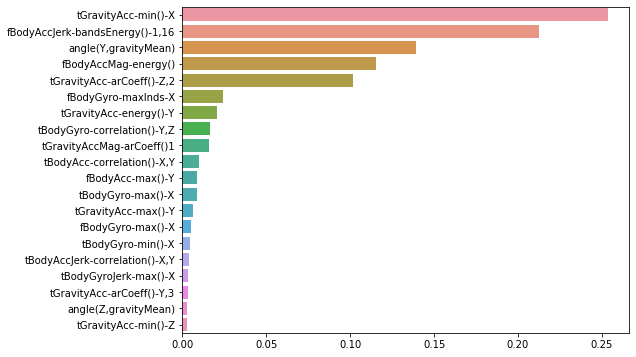

In [32]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)

# 중요도 순으로 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()